# Final project: Stock Prediction

Given the recent stock market history, you will predict the return for ticker AAPL for the day ahead.

# Objectives

You will demonstrate your strengths in several areas, especially
- Exploratory Data Analysis
- Feature Engineering
- Creating, testing and evaluating models
- Error analysis
and Prediction **using Neural Networks**.

Your objective will be to predict next period price returns of a stock given its past prices.

**To be precise**
- given recent prices for AAPL you will predict the next *return*
- *return* will be defined precisely below
- you will be evaluated on a holdout data directory
    - it will have 2 years of data
    - you will be required to predict next period returns for the final 200 days
    - when making a prediction for date $t$, where $t$ is in the holdout data range (**beyond** the last training date)
        - you may use *actual* holdout data for dates strictlty prior to date $t$
        - That is: your prediction for date $t$ *does not* need to be dependent on your *prediction* for date $(t-1)$
    

**Predicting forward returns/prices is hard ! If you could do it well: you would be rich**

Given that fact, out of sample performance will **not** be the sole metric for your grade

This project will test your ability to analyze data, create hypotheses, test them, and improve through iteration.

**You will learn a lot, especially from failures**

This project provides a wealth of opportunity for
- Exploratory data analysis
    - This can suggest several different approaches to building one or more models
- Error Analysis
- Creating, and evaluating models iteratively, learning from past failures and successes.

So your performance will be based on your creativity and experimental process, even if the process
does not lead to great out of sample performance

# The data

As explained in the Final Project Overview:
- you will be given a data directory for training
    - supplied as a compressed archive file in the course's Resource tab in NYU Classes
    - unpacking this file will yield directory `./Data/train`

The data directory will contain one file per ticker, with a history going back many years of fields including
- Price: Close, Open, High, Low
- Volume

"return" means the percent change in the **Close** feature

You will need to 
- decide which files and which fields to use
- prepare the data for training and testing
    - convert from price to return as necessary
    - prepare train and test examples:
    

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline

## Import tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [2]:
# read file 

def getData (data_dir, file):
    
    dataset = pd.read_csv( os.path.join(data_dir, file), index_col = 'Dt' )
    
    return dataset

In [3]:
# Data directory
data_dir = os.path.join(".", "Data", "train")

data = getData(data_dir, 'AAPL.csv')

In [4]:
data.head()

,Adj Close,Close,Div,Factor,High,Low,Open,Volume
Dt,,,,,,,,
2000-01-03,3.4785,111.938,0.0,1.0,112.500,101.688,104.8750,133949200.0
2000-01-04,3.1852,102.500,0.0,1.0,110.625,101.188,108.2500,128094400.0
2000-01-05,3.2318,104.000,0.0,1.0,110.563,103.000,103.7500,194580400.0
2000-01-06,2.9521,95.000,0.0,1.0,107.000,95.000,106.1183,191993200.0
2000-01-07,3.0920,99.500,0.0,1.0,101.000,95.500,96.5000,115183600.0


In [5]:
data.shape

(4277, 8)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 2000-01-03 to 2016-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  4277 non-null   float64
 1   Close      4277 non-null   float64
 2   Div        4277 non-null   float64
 3   Factor     4277 non-null   float64
 4   High       4277 non-null   float64
 5   Low        4277 non-null   float64
 6   Open       4277 non-null   float64
 7   Volume     4277 non-null   float64
dtypes: float64(8)
memory usage: 300.7+ KB


In [7]:
data.describe()

,Adj Close,Close,Div,Factor,High,Low,Open,Volume
count,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4.277000e+03
mean,34.065846,170.450354,0.001999,1.001870,172.424040,168.407568,170.528689,1.299660e+08
std,36.698987,173.484604,0.031011,0.094251,174.989551,171.934671,173.604272,9.970883e+07
min,0.815400,13.120000,0.000000,1.000000,13.190000,12.720000,12.990000,9.835000e+06
25%,3.115300,39.759000,0.000000,1.000000,40.260000,39.030000,39.530000,6.363350e+07
50%,16.948300,106.745000,0.000000,1.000000,108.360000,105.200000,106.959000,1.016484e+08
75%,62.413600,222.250000,0.000000,1.000000,224.980000,217.890000,220.010000,1.679636e+08
max,122.771400,702.100000,0.570000,7.000000,705.070000,699.570000,702.410000,1.855410e+09


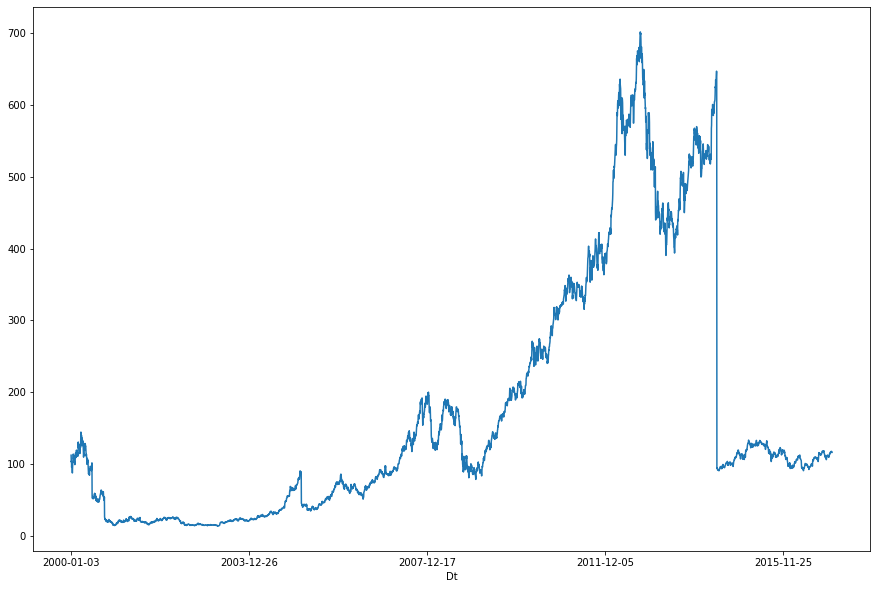

In [8]:
# Data visualization
data['Close'].plot(figsize = (15,10))

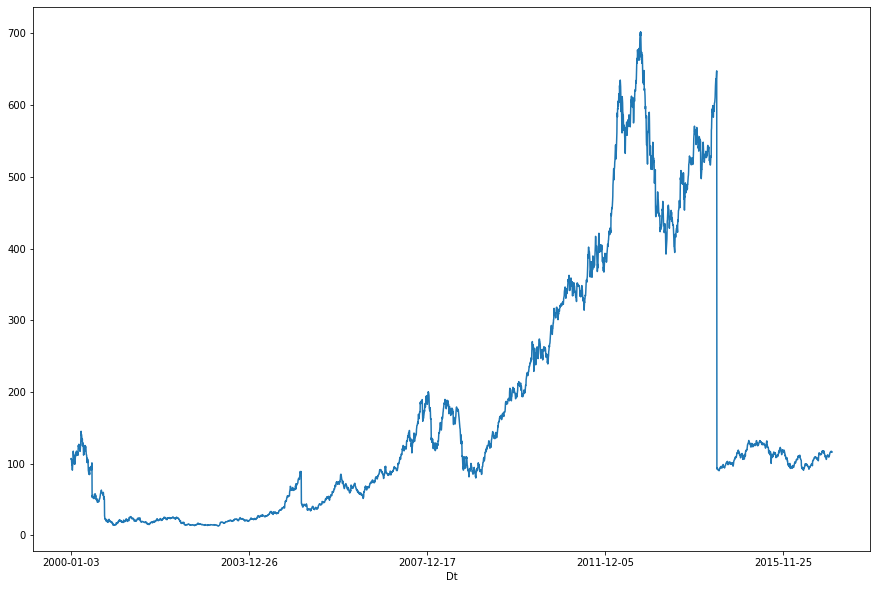

In [10]:
# Midprice visualize
((data["High"] + data["Low"])/2).plot(figsize = (15,10))

**Brief Summary**

Midprice and Close have similar distribution.

## Data preparation

- The files contain prices; your goal is to predict a *return* not a price
- Your goal is to predict the **percent change of the Close feature** ("return")
- Your predicted return for day $t$ should be a function of data occuring *before* day $t$

So your first step will be to create a suitable training set.

For example, the following training set is a good starting point:
- each row is an example
- each row will have a column `Dt` indicating time $t$
- each example has *at least* 20 features
    - derived from AAPL features occuring *before* time $t$
- the target for the row with time $t$ should be the *return* of AAPL for date $t$
    - i.e., the percent price change of AAPL from time $t-1$ to time $t$



## Data Preparation Answer

Since we have two years data in the holdout directory, I also set the out of sample data for two years and in sample data for previous fourteen years. Since stock data is time series data, so I split it consecutively.

Train set: 2000/01/01 - 2014/12/31

Test set: 2015/01/01 - 2016/12/31

Exploratory Data Analysis:

In this section, I have done EDA for training set with following:

- visualize `Close` from training set

- visualize `Return` from training set

- visualize `daily return` from training set

- get training set description


Combined the result from EDA and data visualization from last section, I will add mid-price in the dataset for prediction, because it has similar distribution with `Close`. I will also add the percentage change of mid-price.


Feature Engineering:

In this section, I add `Return` and `daily_return` to the dataset and drop `Close`. This now is just a brief view, I will provide detailed feature engineering later in **Section 6**.

In [11]:
# Create train and test set
train1 = data.loc['2000-01-03':'2014-12-31', :]
test1 = data.loc['2015-01-01':, :]

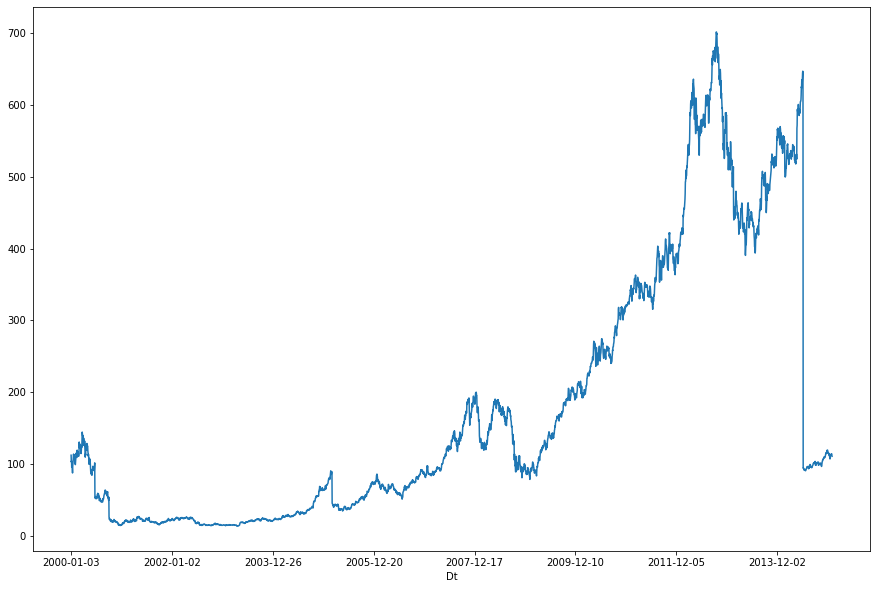

In [12]:
# EDA 
# Close visualize
train1['Close'].plot(figsize = (15,10))

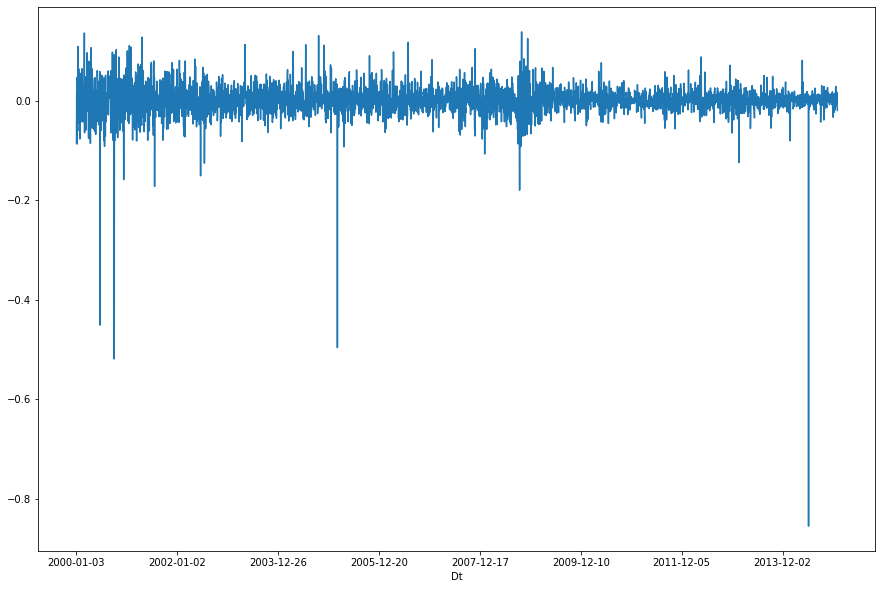

In [13]:
# return visualize
(train1['Close'].pct_change()).plot(figsize = (15,10))

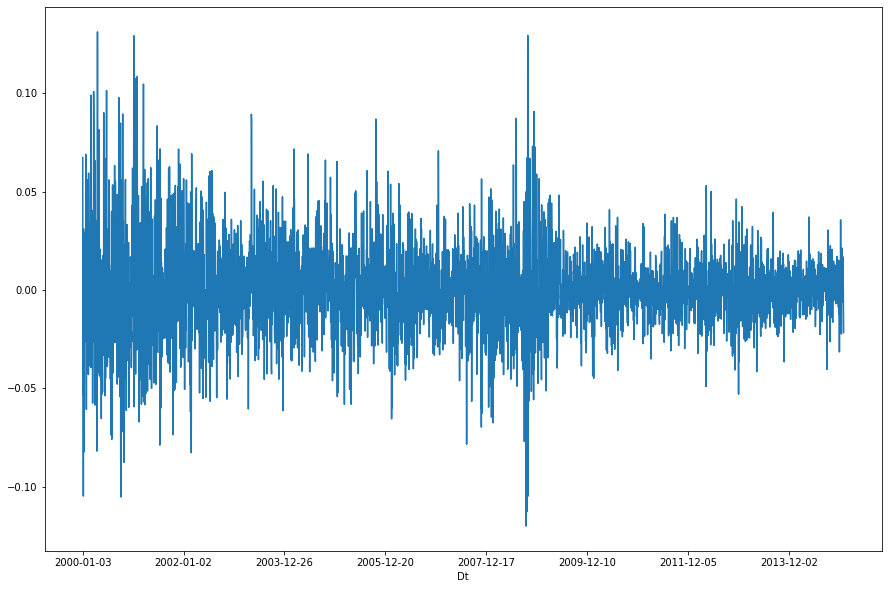

In [14]:
# daily return visualize
((train1['Close']-train1['Open'])/train1['Open']).plot(figsize = (15,10))

In [15]:
# Simple feature engineering
train1['Return'] = train1['Close'].pct_change()
train1['daily_return'] = (train1['Close']-train1['Open'])/train1['Open']
train1 = train1.drop(['Close'], axis = 1)
train1 = train1.dropna()
train1.head()


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Adj Close,Div,Factor,High,Low,Open,Volume,Return,daily_return
Dt,,,,,,,,,
2000-01-04,3.1852,0.0,1.0,110.625,101.188,108.2500,128094400.0,-0.084315,-0.053118
2000-01-05,3.2318,0.0,1.0,110.563,103.000,103.7500,194580400.0,0.014634,0.002410
2000-01-06,2.9521,0.0,1.0,107.000,95.000,106.1183,191993200.0,-0.086538,-0.104773
2000-01-07,3.0920,0.0,1.0,101.000,95.500,96.5000,115183600.0,0.047368,0.031088
2000-01-10,3.0376,0.0,1.0,102.250,94.750,102.0000,126266000.0,-0.017588,-0.041667


In [16]:
test1['Return'] = test1['Close'].pct_change()
test1['daily_return'] = (test1['Close']-test1['Open'])/test1['Open']
test1 = test1.drop(['Close'], axis = 1)
test1 = test1.dropna()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
train1.iloc[1, 7]

0.014634146341463428

In [18]:
## standardize during process 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
# Create dataset for simple model
def Create_dataset(dataset, M):
    X_set = []
    y_set = []
    for i in range (M,dataset.shape[0]):
        X_set.append(sc.fit_transform(dataset.iloc[i-M: i, :].values))
        y_set.append(dataset.iloc[i, 7])
    X_set = np.asarray(X_set)
    y_set = np.asarray(y_set)
        
    return X_set, y_set


In [19]:
Xtrain1, ytrain1 = Create_dataset(train1, 10)
Xtest1, ytest1 = Create_dataset(test1, 10)

In [20]:
#Xtrain1 = np.reshape(Xtrain1,(Xtrain1.shape[0],Xtrain1.shape[1],1))
print(Xtrain1.shape)
print(ytrain1.shape)

(3762, 10, 9)
(3762,)


# Out of sample evaluation

*You* should test your models out of sample.

This will be beneficial as *we* will evaluate your model out of sample using a holdout data directory.

The *holdout data directory* will be for dates that are strictly later than the latest date in the
training data directory.
- will contain 2 years of data
- you will be required to predict the latest 200 returns of AAPL for this holdout directory
- your submission *must work on the holdout directory*
    - you should assume the directory is at relative path  `./data/holdout`

So you might want to create your own validation/test data (from the training data directory) that mimics
what the holdout data directory will contain.

It is up to you to decide on the out of sample data that you use for model development.


# Suggestions for  getting started

The problem we presented to you is unstructured and not precisely defined in full detail.

- Start by defining, in detail,  the problem that you will attempt to solve
    - Do you view this as a Regression task ?  A Classification task
    - Justify your choice
~ Define the Performance Metric that you think is appropriate
    - Justify your choice

- Start with a simple model, using only data from AAPL (few features)
    - Use the model to get a feel for the problem
    - Will be a good baseline
    - Will help you form new hypotheses to test
        - may guide the choice of additional features
- Create new models iteratively
    - Train and evaluate a "simpler" model
    - Evalute performance
    - Perform error analysis
    - Propose a new "less simple" model
        - add as many features as you like, from any file in the directory

- Be disciplined in your process: avoid repeating code
    - It will be easier if you have a single piece of code that works for
        - the training directory
        - the test directory (that you might choose to create)
        - the holdout directory
    - This will
        - simplify your process
        - help ensure that your submission will work on the holdout directory !
   

**Answer**

- We view this as Regression task, because `Return` is continuous variable, we cannot use Classification method to catagorize. Normally, we use mean square error as the loss function to evaluate the model.

- **Section 5.1** provides us a simple model using only data from AAPL and a model with few LSTM layers.

- **Section 6** builds up a much more complicate model, based on the error analysis we made for the simple model. 

## Model 1 Simple Model with only AAPL data

In [21]:
# Call_back Function
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
modelName = "callback_func"

es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=.0, 
                                               patience=3, verbose=0, 
                                               mode='auto', baseline=None, 
                                               restore_best_weights=True)
callbacks = [ es_callback, ModelCheckpoint(filepath=modelName + ".ckpt", monitor='loss', save_best_only=True)]

### Build up Model

In [22]:
# Build up single model first
## standardize import
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, BatchNormalization, Flatten


In [23]:
# build up mode
lstm = Sequential()
# Add first layer
lstm.add(LSTM(units = 50, return_sequences = True, input_shape = (Xtrain1.shape[1], Xtrain1.shape[2])))
lstm.add(Dropout(0.2))
# Add second layer
lstm.add(LSTM(units = 50, return_sequences = True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units = 50))
# add output layer
lstm.add(Dense(units = 1))
print(lstm.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 50)            12000     
_________________________________________________________________
dropout (Dropout)            (None, 10, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 52,451
Trainable params: 52,451
Non-trainable params: 0
____________________________________________________

In [24]:
# Compiling LSTM 
lstm.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

lstm.fit(Xtrain1, ytrain1, epochs = 10, batch_size = 32, callbacks = callbacks)

Train on 3762 samples
Epoch 1/10
3744/3762 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 0.0069WARNING:tensorflow:From /opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: callback_func.ckpt/assets
3762/3762 [==============================] - 32s 8ms/sample - loss: 0.0013 - accuracy: 0.0069
Epoch 2/10
3762/3762 [==============================] - 23s 6ms/sample - loss: 0.0011 - accuracy: 0.0069
Epoch 3/10
3762/3762 [==============================] - 9s 2ms/sample - loss: 0.0011 - accuracy: 0.0069
Epoch 4/10
3762/3762 [==============================] - 22s 6ms/sample - loss: 0.0011 - accuracy: 0.0069
Epoch 5/10
3762/3762 [========================

### Error Analysis for Simple Model
- Number of parameters
- Mean Square Error loss and accuracy


In [25]:
# Number of parameters
num_parameters0 = lstm.count_params()

print("Parameters number in first LSTM model: ", num_parameters0)

Parameters number in first LSTM model:  52451


In [26]:
score0 = lstm.evaluate(Xtest1, ytest1)

print("{n:s}: Test loss: {l:5.4f} / Test accuracy: {a:5.4f}".format(n = "First LSTM model", l=score0[0], a=score0[1]))

493/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

First LSTM model: Test loss: 0.0003 / Test accuracy: 0.0020


### Brief Summary

This model builds up a baseline. 
The main purpose is to verify that my process is on the right track. 
It only has 3 layers with 9 features. Return and daily return are two features we added in this model.

The last in-sample result is `- loss: 0.0011 - accuracy: 0.0069`. 

This model has 52451 parameters, and provides a result that `- loss: 1.4290e-04 - accuracy: 0.0020`. To improve the model, I will:

- add more featuers in the dataset by either calculate relavant variables or import other stocks' features
- add more layers and optimize the parameters in LSTM model

# Complex Model

In this model, we will keep the training set 2000/01/03 - 2014/12/31 and testing set 2015/01/01 - 2016/12/31. Based on the Exploratory data analysis we did before, I will add variables to at least 20 features in the model for feature engineering. Then, with the same process for creating X_train y_train X_test y_test datasets, I will improve the LSTM model by changing parameters. 

To make sure that there is no repeat coding or overlapping dataset, I split the dataset again to make sure all the data are clear enough. 

## Feature engineering and Data Exploratory

In [27]:
# Create train and test set
train = data.loc['2000-01-03':'2014-12-31', :]
test = data.loc['2015-01-01':, :]

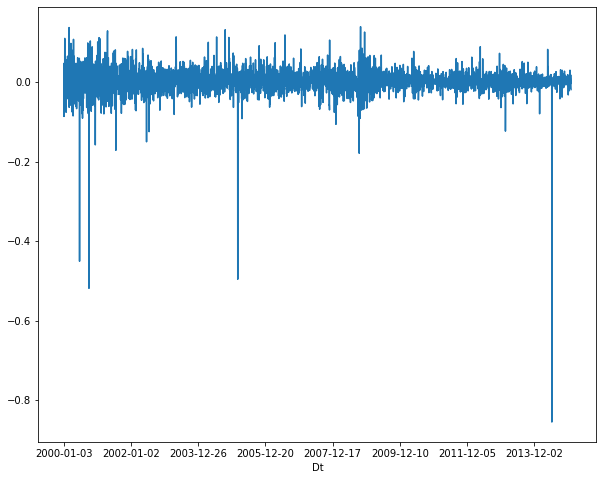

In [30]:
# EDA 
# Return visualize
(train['Close'].pct_change()).plot(figsize = (10,8))

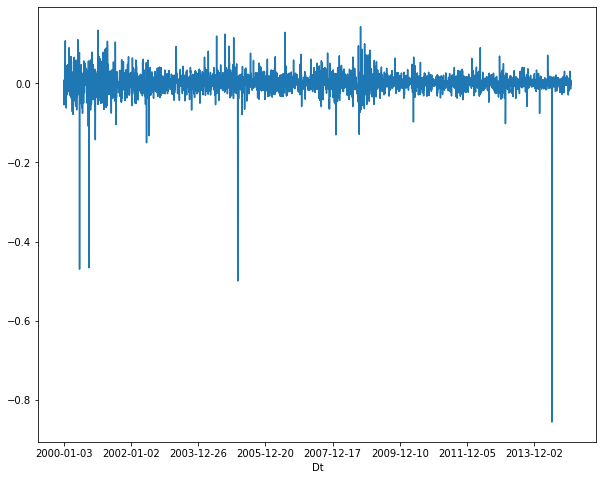

In [32]:
# Return visualize
(((train['Low'] + train['High'])/2).pct_change()).plot(figsize = (10,8))

In [33]:
# feature engineering 

def feature_engineering(df):
    df['Return'] = df["Close"].pct_change()
    df['daily_return'] = (df['Close']-df['Open'])/df['Open']
    df['Mid_price_daily'] = (df['Close'] + df['Open'])/2
    df['Mid_price'] = (df['Low'] + df['High'])/2
    df['Mid_price_pct'] = df['Mid_price'].pct_change() 
    df['Volatility_week'] = df["Close"].pct_change().rolling(5).std()
    df['MA_week'] = df["Close"].pct_change().rolling(5).mean()
    df['Direction'] = df['Return'].map(lambda x: 0 if x == 0 else x/abs(x))
    df['Dir_change'] = (df['Direction'].shift(1) != df['Direction']).astype(int)
    df['Return_brucket'] = 0
    df.loc[df['Return']>= 0.01, 'Return_brucket'] = 1
    df.loc[df['Return']<= -0.01, 'Return_brucket'] = -1
    df['Prev_open_rate'] = (df['Open']-df['Close'].shift(1))/df['Close'].shift(1)
    df['Volatility_Open_week'] = df['Open'].pct_change().rolling(5).std()
    df['MA_week_Daily'] = df['daily_return'].rolling(5).mean()
    df['Direction_Daily'] = df['daily_return'].map(lambda x: 0 if x == 0 else x/abs(x))
    df['Dir_change_daily'] = (df['Direction_Daily'].shift(1) != df['Direction_Daily']).astype(int)
    
    df = df.dropna()
    
    return df


In [34]:
# import two other stock data and prepare the data
ADBE = getData(data_dir, 'ADBE.csv')
MSFT = getData(data_dir, 'MSFT.csv')

In [35]:
# Rename data title
def Rename(df, ticker):

        rename_map = { orig:  ticker + "_" + orig.replace(" ", "_") for orig in df.columns.to_list() }
        
        return df.rename(columns=rename_map)

In [36]:
ADBE = Rename(ADBE, "ADBE")
MSFT = Rename(MSFT, "MSFT")

In [37]:
ADBE['ADBE_Return'] = ADBE['ADBE_Close'].pct_change()
MSFT['MSFT_Return'] = MSFT['MSFT_Close'].pct_change()

In [38]:
# feature engineering for train and test dataset
train = feature_engineering(train)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [39]:
test = feature_engineering(test)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [40]:
# Merge AAPL with ADBE and MSFT
train['ADBE_ret'] = ADBE['ADBE_Return']
train['MSFT_ret'] = MSFT['MSFT_Return']

In [41]:
train.head()

,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return,daily_return,...,Direction,Dir_change,Return_brucket,Prev_open_rate,Volatility_Open_week,MA_week_Daily,Direction_Daily,Dir_change_daily,ADBE_ret,MSFT_ret
Dt,,,,,,,,,,,,,,,,,,,,,
2000-01-10,3.0376,97.750,0.0,1.0,102.2500,94.750,102.000,126266000.0,-0.017588,-0.041667,...,-1.0,1,-1,0.025126,0.060553,-0.033212,-1.0,1,0.038610,0.007287
2000-01-11,2.8822,92.750,0.0,1.0,99.3750,90.500,95.938,110387200.0,-0.051151,-0.033230,...,-1.0,0,-1,-0.018537,0.060713,-0.029234,-1.0,0,-0.068773,-0.025612
2000-01-12,2.7094,87.188,0.0,1.0,95.5012,86.500,95.000,244017200.0,-0.059968,-0.082232,...,-1.0,0,-1,0.024259,0.059857,-0.046163,-1.0,0,-0.004982,-0.032567
2000-01-13,3.0065,96.750,0.0,1.0,98.7500,92.500,94.484,258171200.0,0.109671,0.023983,...,1.0,1,1,0.083681,0.056515,-0.020411,1.0,1,0.053151,0.018901
2000-01-14,3.1211,100.438,0.0,1.0,102.2500,99.375,100.000,97594000.0,0.038119,0.004380,...,1.0,0,1,0.033592,0.049955,-0.025753,1.0,0,0.010484,0.041155


In [43]:
# check correlation
train_cor = train.corr(method = 'pearson')

In [44]:
train_cor['Return'].sort_values(ascending = False)

Return                  1.000000
Mid_price_pct           0.824646
Prev_open_rate          0.721758
Return_brucket          0.683481
daily_return            0.657195
Direction               0.590043
Direction_Daily         0.474874
MA_week                 0.455472
ADBE_ret                0.319077
MSFT_ret                0.301528
MA_week_Daily           0.273744
Close                   0.012788
Low                     0.008864
Mid_price_daily         0.008564
Mid_price               0.008411
High                    0.007965
Dir_change_daily        0.006300
Dir_change              0.006138
Open                    0.004342
Adj Close              -0.007107
Div                    -0.011194
Volume                 -0.046981
Volatility_week        -0.226202
Volatility_Open_week   -0.231775
Factor                 -0.487838
Name: Return, dtype: float64

In [45]:
# Merge AAPL with ADBE and MSFT for test data
test['ADBE_ret'] = ADBE['ADBE_Return']
test['MSFT_ret'] = MSFT['MSFT_Return']

- **Create X and y datasets**

In [46]:
# Create dataset for simple model
def Create_dataset(dataset, M):
    X_set = []
    y_set = []
    for i in range (M,dataset.shape[0]):
        X_set.append(sc.fit_transform(dataset.iloc[i-M: i, :].values))
        y_set.append(dataset.iloc[i, 8])
    X_set = np.asarray(X_set)
    y_set = np.asarray(y_set)
        
    return X_set, y_set

In [47]:
X_train, y_train = Create_dataset(train, 10)
X_test, y_test = Create_dataset(test, 10)

In [48]:
print(X_train.shape)
print(y_train.shape)

(3758, 10, 25)
(3758,)


In [49]:
y_train

array([ 0.05647059, -0.01836971, -0.00170617, ..., -0.00070182,
       -0.01220262, -0.01901884])

## Build Up Models

### Simple RNN model

In [71]:
from tensorflow.keras.layers import SimpleRNN
model_name = 'SimpleRNN'

model = Sequential()
model.add(SimpleRNN(32, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(SimpleRNN(32, return_sequences = True))
model.add(SimpleRNN(32))
model.add(Dense(1))

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 10, 32)            1856      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 10, 32)            2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________
None


**Error Analysis**

In [51]:
# Compiling Model
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

# fit RNN model
_=model.fit(X_train, y_train, epochs = 10, batch_size = 32, callbacks = callbacks)

Train on 3758 samples
Epoch 1/10
3758/3758 [==============================] - 7s 2ms/sample - loss: 0.0408 - accuracy: 0.0067
Epoch 2/10
3758/3758 [==============================] - 4s 1ms/sample - loss: 0.0027 - accuracy: 0.00690s - loss: 0.0025 - accuracy
Epoch 3/10
3758/3758 [==============================] - 3s 854us/sample - loss: 0.0018 - accuracy: 0.0069
Epoch 4/10
3758/3758 [==============================] - 3s 868us/sample - loss: 0.0015 - accuracy: 0.0069
Epoch 5/10
3758/3758 [==============================] - 3s 768us/sample - loss: 0.0014 - accuracy: 0.0069
Epoch 6/10
3758/3758 [==============================] - 3s 853us/sample - loss: 0.0013 - accuracy: 0.0069 - los
Epoch 7/10
3758/3758 [==============================] - 3s 895us/sample - loss: 0.0013 - accuracy: 0.0069
Epoch 8/10
3758/3758 [==============================] - 3s 768us/sample - loss: 0.0013 - accuracy: 0.0069
Epoch 9/10
3758/3758 [==============================] - 3s 811us/sample - loss: 0.0012 - accuracy: 0

In [72]:
# Number of Parameters
num_parameters3 = model.count_params()

print("Parameters number in SimpleRNN Model: ", num_parameters1)

Parameters number in SimpleRNN Model:  6049


In [53]:
# Evaluate RNN model
score1 = model.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:5.4f} / Test accuracy: {a:5.4f}".format(n = model_name, l=score1[0], a=score1[1]))

489/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

SimpleRNN: Test loss: 0.0006 / Test accuracy: 0.0020


**Brief Summary**

- In-sample loss and accuracy ends with `- loss: 0.0012 - accuracy: 0.0069`
- We have 6017 parameters
- The result is `- loss: 4.2527e-04 - accuracy: 0.0020`. 

### LSTM Model

In [54]:
# Callback model
# Call_back Function for val_loss
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
modelName = "callback_model"

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.0, 
                                               patience=3, verbose=0, 
                                               mode='auto', baseline=None, 
                                               restore_best_weights=True)
callbacks = [ es_callback, ModelCheckpoint(filepath=modelName + ".ckpt", monitor='val_loss', save_best_only=True)]

In [55]:
# plot model for predicted return and true return
def plot(model, y_pred, rmse):
     
    fig, axs = plt.subplots(figsize = (12, 8))
    axs.plot(test['Return'][10:], label = "True Return")
    axs.plot(y_pred, label = "Predicted Return (RMSE = {:0.5f})".format(rmse))
    #axs.set_xticks(test['Return'].index[10:])
    #axs.set_xticklabels(test['Return'].index[10:][::2], rotation=45)
    axs.legend()
    
    return fig, axs

In [56]:
def model(X, y, M, units, epochs, batch_size, val_rate):
    lstm = Sequential()
    
    lstm.add(LSTM(units = units, return_sequences = True, input_shape = (M, X.shape[2])))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units = int(units/2), return_sequences = True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units = int(units/4), return_sequences = True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units = int(units/4)))
    
    lstm.add(Dense(units = 1))
    print(lstm.summary())
    
    lstm.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    lstm.fit(X, y, epochs = epochs, batch_size = batch_size, validation_split = val_rate, callbacks = callbacks)
    
    return lstm

#### Model 2

In [57]:
model_name = 'model_2'
model_2 = model(X_train, y_train, 10, 256, 10, 32, 0.1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 256)           288768    
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 128)           197120    
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 64)            49408     
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)               

**Error Analysis**

In [60]:
# Number of Parameters Model2
num_parameters2 = model_2.count_params()

print("Parameters number in LSTM model 2: ", num_parameters2)

Parameters number in LSTM model 2:  568385


In [61]:
# Model_2 Evaluation
score2 = model_2.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:5.4f} / Test accuracy: {a:5.4f}".format(n = model_name, l=score2[0], a=score2[1]))

489/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

model_2: Test loss: 0.0002 / Test accuracy: 0.0020


In [62]:
# Predicted value and RMSE
y_pred = model_2.predict(X_test)
rmse = np.sqrt(np.mean(np.square(y_test - y_pred)))
print("RMSE in LSTM model: ", rmse)

RMSE in LSTM model:  0.015738520054079917


(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a97936a50>)

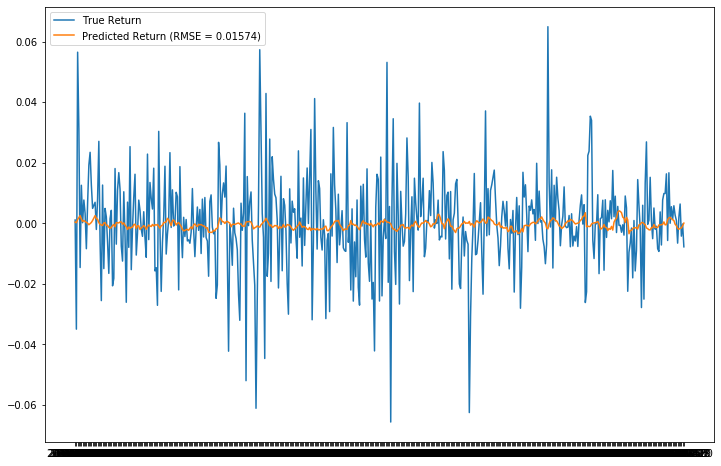

In [63]:
plot(model_2, y_pred, rmse)

#### Model 3

In [64]:
model_name = 'model_3'
model_3 = model(X_train, y_train, 10, 1024, 10, 32, 0.1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10, 1024)          4300800   
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 1024)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 10, 512)           3147776   
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 10, 256)           787456    
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 256)              

**Error Analysis**

In [65]:
# Number of Parameters Model3
num_parameters3 = model_3.count_params()

print("Parameters number in LSTM model: ", num_parameters3)

Parameters number in LSTM model:  8761601


In [66]:
score3 = model_3.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:5.4f} / Test accuracy: {a:5.4f}".format(n = model_name, l=score3[0], a=score3[1]))

489/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

model_3: Test loss: 0.0002 / Test accuracy: 0.0020


In [67]:
# Predicted value and RMSE
y_pred = model_3.predict(X_test)
rmse = np.sqrt(np.mean(np.square(y_test - y_pred)))
print("RMSE in LSTM model: ", rmse)

RMSE in LSTM model:  0.015857325249132675


(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1add909a50>)

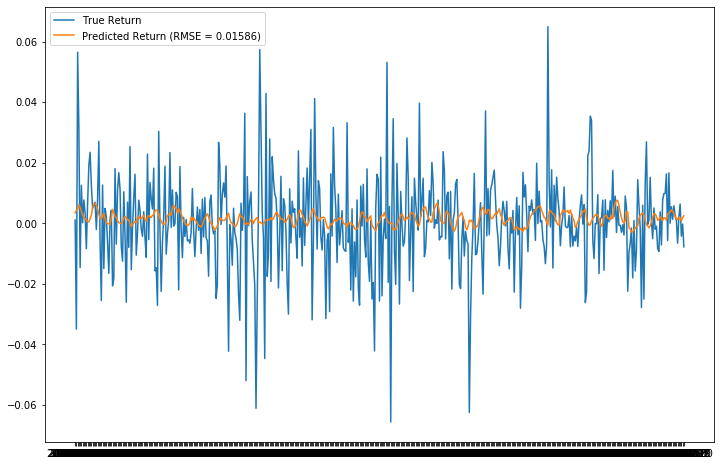

In [68]:
plot(model_3, y_pred, rmse)

### Error Analysis

Mean Squared Error (MSE) and Rooted Mean Squared Error (RMSE) are commonly used regression function. Compared with simple LSTM model and Simple RNN Model, Complex LSTM model provides the prediction with less loss. The main purpose of Model_2 and Model_3 is to find out optimizied parameters. 

In this section, we provide the error analysis for Model_2 and Model_3 based on 4 following aspects:

- Number of paramters
- Loss score and accuracy score
- RMSE
- plot between predicted and true return

First, Model 2 has 568385 parameters and Model 3 has 8761601 parameters, Model 3 has more parameters.

Then, Model 2 has in sample loss and accuracy: `- loss: 9.7756e-04 - accuracy: 0.0074 `, while Model 3 has in sample loss and accuracy: `- loss: 9.7251e-04 - accuracy: 0.0074`.

Model 2 has out-of-sample loss and accuracy: `- loss: 1.3506e-04 - accuracy: 0.0020`. while Model 3 has out-of-sample loss and accuracy: `- loss: 1.3719e-04 - accuracy: 0.0020`.

Model 2 has RMSE: 0.015739 and Model 3 has RMSE: 0.015857.

Lastly, figures ploted above show that the prediction in Model_2 has fluctuated volatility than the prediction in Model_3, which corresponds to the trend of true return more. 

In total, we have four models: a simple LSTM model, a simpleRNN model, two complicated LSTM model (Model 2 and Model 3). Compared with the performance, the complicated LSTM model provides better performance than others.

Based on the error analysis above, I chose Model_2 as my_model to predict holdout data for project evaluation in **Section 7**, because Model 2 provides a slightly better result with less time consumption.

# Save Model and Build MyModel

In [73]:
import os
from tensorflow.keras.models import load_model

modelName = "final_model"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
        
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))
    

In [74]:
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    
    return model


In [75]:
def MyModel(test_dir, model_path):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_path)
    
    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # We need to match your array of predictions with the examples you are predicting
    # The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
    # For Bankruptcy: the Id column
    # For Stock prediction: the date on which you are making a prediction
    ids = []
    
    # YOUR CODE GOES HERE
    # Get holdout dataset as test data
    data = getData(test_dir, 'AAPL.csv')
    
    # feature engineering
    ADBE = getData(test_dir, 'ADBE.csv')
    MSFT = getData(test_dir, 'MSFT.csv')
    ADBE = Rename(ADBE, "ADBE")
    MSFT = Rename(MSFT, "MSFT")
    ADBE['ADBE_Return'] = ADBE['ADBE_Close'].pct_change()
    MSFT['MSFT_Return'] = MSFT['MSFT_Close'].pct_change()
    test = feature_engineering(data)
    test['ADBE_Return'] = ADBE['ADBE_Return']
    test['MSFT_Return'] = MSFT['MSFT_Return']
    
    # create X and y dataset
    X_test, y_test = Create_dataset(test, 10)
    
    # make prediction
    predictions = model.predict(X_test)
    
    # get index
    ids = test.index
    
    return predictions, ids


## Notification

In the feature engineering, there is a step to produce volatility return for 5 days, which results first 5 days containing Nan value, and has been droped in the last step. Therefore, the prediction starts from the sixth day of the test set.

In [76]:
# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
my_model = model_2 # CHANGE None to your model !

saveModel(my_model, model_path)

Directory ./final_model already exists, files will be over-written.
Model saved in directory ./final_model; create an archive of this directory and submit with your assignment.


In [ ]:
holdout_dir = os.path.join(".", "Data", "holdout")
predicts = MyModel(holdout_dir, model_path)

# Warning: Avoid looking into the future !

Obviously, you should not use knowledge of the future to predict future prices.

But it is surprisingly easy to inadvertantly do so !  For example:
- when standardizing a data set: you might compute averages and standard deviations over the full range of dates
    - this means that the earliest dates have implicit knowledge of later dates
        - for example, suppose the mean increases after 10 days
        - the observations of the first 9 days *should not know* that the mean of the entire data range is different than what is available from earlier observations

# Evaluating your model
   
Your goals
- demonstrate that your models can predict in-sample (based on training only) somewhat successfully
    - this is easier than predicting out of sample
    - this will show that your model has "learned" something
- evaluate your model out of sample using the validation/test set you created
- run multiple experiments to try to improve out of sample prediction
- present a "final model" which we will evaluate with a holdout dataset
     - The holdut dataset will be identical in structure to the full data set we provide
     - *BUT* the dates will be strictly after the dates in the full dataset.

# Final reminder: document your thought process

**The key to getting a good grade** is to
- document everything you do
- justify the many choices you will have to make -- use data and intuition to back up your statements
- report on failed theories/experiments
    - it shows the amount of effort you expended
    - tell us
        - why you thought it was a good idea to try
        - what you learned from the failure
        - how the failure led you to try something different
        
The out of sample prediction is hard -- you may or may not do well.

What is important is to see how you tried to improve and how failure as well as success led to
better experiments.

In [80]:
print("Done")

Done
